In [1]:
import numpy as np 
import pandas as pd
import sklearn

import os

In [248]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from plotnine import *

In [6]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV

In [3]:
trainData = pd.read_csv("./data/train.csv")
testData = pd.read_csv("./data/test.csv")

In [4]:
outliers = ((trainData.GrLivArea > 4000) & (trainData.SalePrice < 5E5))
trainData = trainData[~(outliers)]

In [222]:
groupNeighborhoods = ["NPkVill","Blueste","BrDale","MeadowV"]
trainData.Neighborhood[trainData.Neighborhood.isin(groupNeighborhoods)] = "grouped"
testData.Neighborhood[testData.Neighborhood.isin(groupNeighborhoods)] = "grouped"

In [554]:
# indices for submission
trainBoro = trainData.groupby("Neighborhood")["Id"].apply(np.array).to_dict()
testBoro = testData.groupby("Neighborhood")["Id"].apply(np.array).to_dict()

In [578]:
# Indices as they appear in the dataframe
trainBoro_dfidx = trainData.reset_index().groupby("Neighborhood").apply(lambda x: x.index.values).to_dict()
testBoro_dfidx = testData.reset_index().groupby("Neighborhood").apply(lambda x: x.index.values).to_dict()

In [579]:
trainData.shape

(1458, 83)

In [580]:
trainBoro_dfidx["Edwards"]

array([  39,   97,   98,  110,  117,  145,  155,  165,  175,  182,  193,
        200,  210,  211,  239,  269,  292,  308,  352,  362,  375,  386,
        387,  390,  395,  410,  418,  439,  441,  445,  472,  502,  527,
        534,  552,  561,  562,  581,  606,  619,  637,  646,  650,  658,
        662,  670,  696,  722,  723,  737,  748,  770,  771,  813,  838,
        879,  886,  916,  920,  941,  953,  977,  984,  999, 1010, 1019,
       1034, 1044, 1048, 1052, 1071, 1072, 1087, 1121, 1122, 1143, 1150,
       1167, 1178, 1184, 1211, 1253, 1256, 1272, 1293, 1296, 1302, 1312,
       1317, 1324, 1330, 1375, 1378, 1382, 1421, 1446, 1450, 1457])

In [582]:
{i: min(j) for i,j in trainBoro_dfidx.items()}

{'Blmngtn': 219,
 'BrkSide': 9,
 'ClearCr': 69,
 'CollgCr': 0,
 'Crawfor': 3,
 'Edwards': 39,
 'Gilbert': 50,
 'IDOTRR': 21,
 'Mitchel': 5,
 'NAmes': 14,
 'NWAmes': 7,
 'NoRidge': 4,
 'NridgHt': 11,
 'OldTown': 8,
 'SWISU': 267,
 'Sawyer': 10,
 'SawyerW': 18,
 'Somerst': 6,
 'StoneBr': 58,
 'Timber': 41,
 'Veenker': 1,
 'grouped': 23}

In [542]:
for i,j in trainBoro.items():
    print(f'{i}:  {len(j)}')

Blmngtn:  17
BrkSide:  58
ClearCr:  28
CollgCr:  150
Crawfor:  51
Edwards:  98
Gilbert:  79
IDOTRR:  37
Mitchel:  49
NAmes:  225
NWAmes:  73
NoRidge:  41
NridgHt:  77
OldTown:  113
SWISU:  25
Sawyer:  74
SawyerW:  59
Somerst:  86
StoneBr:  25
Timber:  38
Veenker:  11
grouped:  44


In [5]:
zoning = trainData.groupby("Neighborhood").MSZoning.apply(lambda x: x.value_counts().sort_values().index[0]).to_dict()
utilities = trainData.groupby("Neighborhood").Utilities.apply(lambda x: x.value_counts().sort_values().index[0]).to_dict()
frontage = trainData.groupby("Neighborhood").LotFrontage.apply(lambda x: x.value_counts().sort_values().index[0]).to_dict()

In [7]:
# Don't know what to do with these yet
# Maybe harmonic transform on month. 
# Maybe diff between year sold and built
timeVars = ["YrSold","YearBuilt"]

# CentralAir needs to be examined for correlation
toInclude = ["LotFrontage","Electrical","Functional","MSZoning","Utilities",
            "KitchenQual","SaleType","Exterior1st","Exterior2nd","CentralAir"]

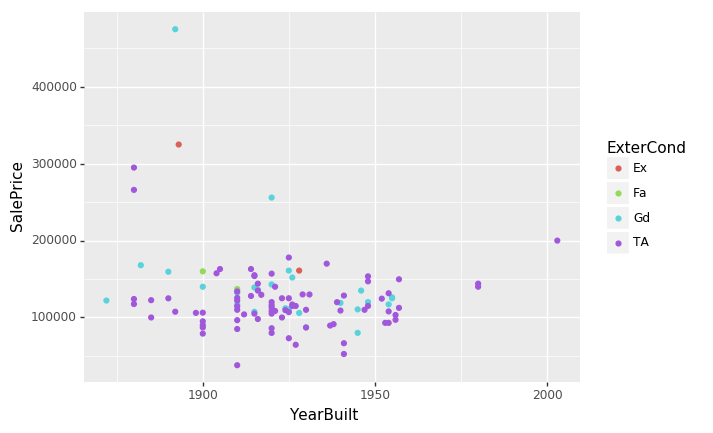

<ggplot: (8730823225320)>

In [111]:
(ggplot(trainData[trainData.Neighborhood == "OldTown"], aes(x="YearBuilt",y="SalePrice")) + 
        geom_point(aes(color="ExterCond")))

In [243]:
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.graphics.regressionplots import plot_fit

In [261]:
raw_X = trainData.OverallQual.values.reshape(-1,1)
OLS_y = trainData.SalePrice


features = sm.add_constant(raw_X)
ols_sm   = OLS(OLS_y.values,features)
raw_model    = ols_sm.fit()

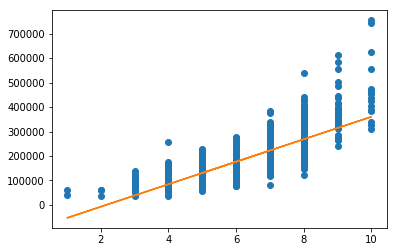

In [259]:
plt.plot(OLS_X,OLS_y,"o")
plt.plot(OLS_X,raw_model.fittedvalues)

In [351]:
def testPow(n):
    X = raw_X**n
    features = sm.add_constant(X)
    ols_sm   = OLS(OLS_y.values,features)
    model    = ols_sm.fit()
    return model.rsquared

pws = [testPow(i) for i in np.linspace(2.5,3.5,50)]
condPow = np.linspace(2.5,3.5,50)[np.argmax(pws)]
print(condPow)
print(np.max(pws))

3.2959183673469385
0.6995463333306919


In [299]:
quad_X = raw_X**2.

features = sm.add_constant(quad_X)
ols_sm   = OLS(OLS_y.values,features)
quad_model    = ols_sm.fit()

quad_model.rsquared

0.6799353758974964

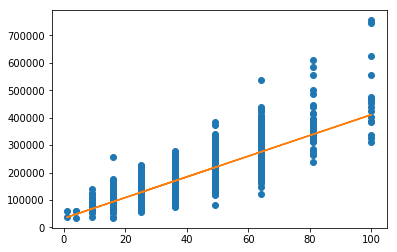

In [300]:
plt.plot(quad_X,OLS_y,"o")
plt.plot(quad_X,quad_model.fittedvalues)

In [336]:
def getPowDict(varList, _range = np.linspace(0.1,4,200)):
    out = {}
    def recPow(varname, n):
        X = trainData[varname].values.reshape(-1,1)
        y = trainData.SalePrice.values
        features = sm.add_constant(X**n)
        ols = OLS(y,features)
        model = ols.fit()
        return model.rsquared
        
    for var in varList:
        pws = [recPow(var,i) for i in _range]
        out[var] = _range[np.argmax(pws)]
    return out

In [396]:
getPowDict(["OverallQual"], np.linspace(0.1,4,200))

{'OverallQual': 3.2944723618090457}

In [468]:
trainData.BsmtCond.value_counts()

TA    1309
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

                   mean           std  count
MSZoning                                    
C (all)    74528.000000  33791.092031     10
FV        214014.061538  52369.662067     65
RH        131558.375000  35714.118435     16
RL        191037.422977  80831.267725   1149
RM        126316.830275  48521.689833    218


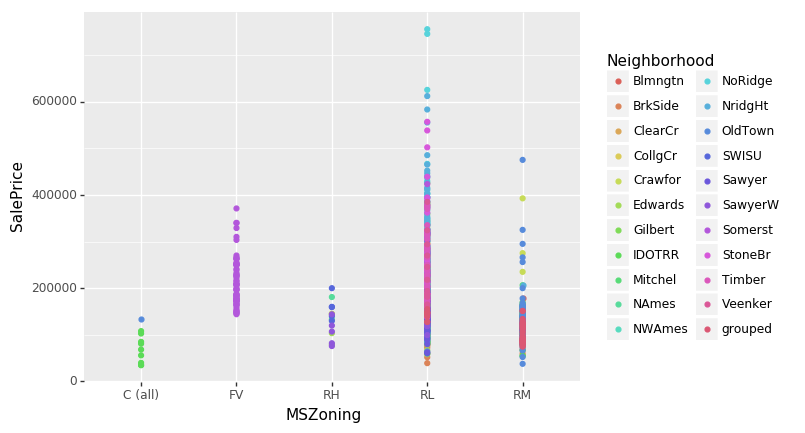

<ggplot: (8730822207615)>


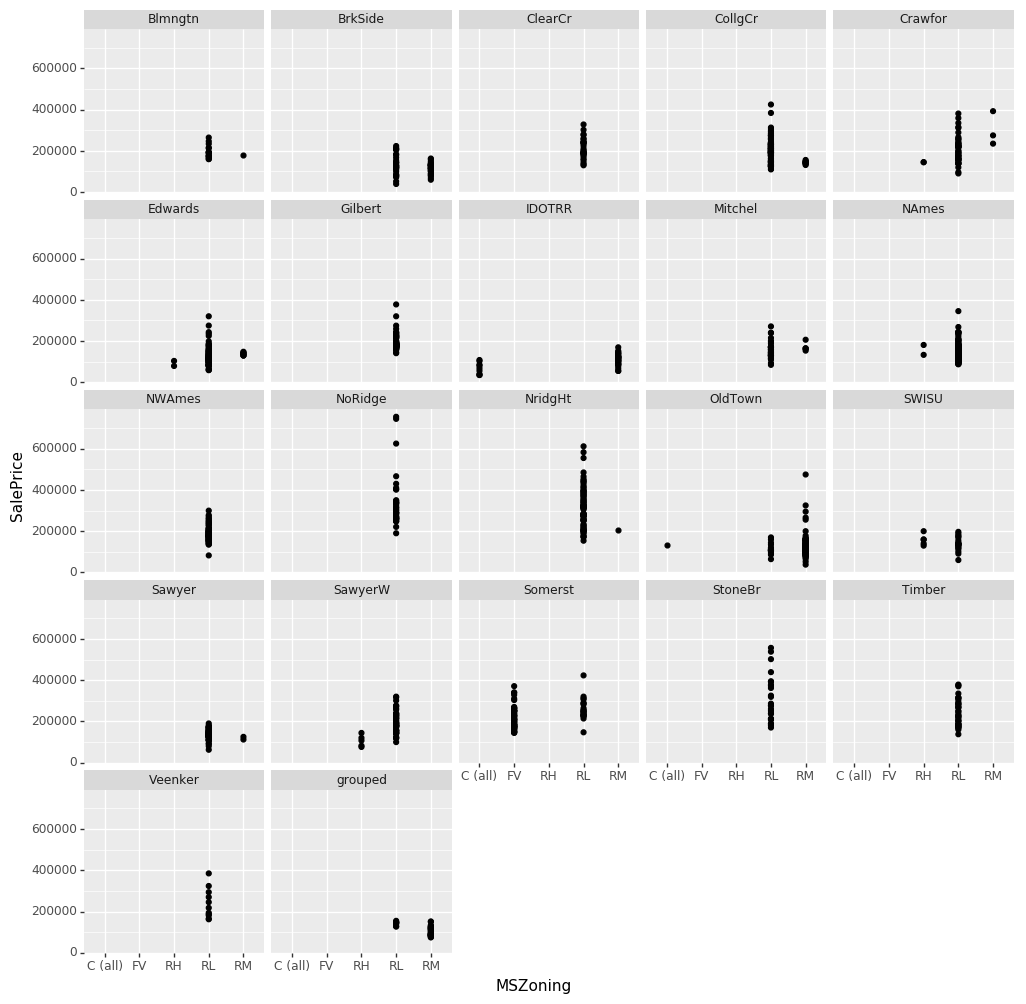

<ggplot: (8730822207531)>


In [504]:
curVar = "MSZoning"
print(trainData.groupby(curVar).SalePrice.agg(["mean","std","count"]))
g1 = ggplot(trainData, aes(x=curVar,y="SalePrice")) + geom_point(aes(color="Neighborhood"))
g2 = ggplot(trainData, aes(x=curVar,y="SalePrice")) + geom_point() + facet_wrap("Neighborhood") + theme(figure_size=(12,12))

print(g1)
print(g2)

In [ ]:
potential deletes:
    
    RoofStyle
    RoofMatl
    Exterior2nd
    MasVnrType
    BsmtFinSF2
    Functional
    GarageCond
    ScreenPorch

In [501]:
testData.LandSlope.isnull().sum()

0

In [502]:
for i in fillNone:
    if (testData[i].isnull().sum()):
        print(i)


BsmtQual
MasVnrType
BsmtExposure
BsmtFinType1
BsmtFinType2
GarageType
GarageFinish
GarageQual
GarageCond
BsmtCond
FireplaceQu
PoolQC
Fence
MiscFeature
MasVnrType
MSZoning


In [503]:
for i in fillNone:
    if (trainData[i].isnull().sum()):
        print(i)

BsmtQual
MasVnrType
BsmtExposure
BsmtFinType1
BsmtFinType2
GarageType
GarageFinish
GarageQual
GarageCond
BsmtCond
FireplaceQu
PoolQC
Fence
MiscFeature
MasVnrType
Electrical



SaleType
SaleCondition
SalePrice


In [505]:
## These are for the linear model
selected=[]
# values that null is filled with "None"
fillNone = ["BsmtQual","MasVnrType","BsmtExposure","BsmtFinType1","BsmtFinType2",
            "GarageType","GarageFinish","GarageQual","GarageCond","BsmtCond","FireplaceQu",
            "PoolQC","Fence","MiscFeature","MasVnrType","LotShape","LandSlope",
           "Condition1","LotConfig","BldgType","HouseStyle","RoofStyle","RoofMatl","ExterQual",
           "ExterCond","Foundation","Heating","HeatingQC","SaleCondition", "Electrical", "PavedDrive"]

# ordinal categorical variables
fillZeroCat = ["BsmtFullBath","HalfBath","OverallQual","MSSubClass","YrSold"]

# continuous variables with missing values that are zero
fillZeroCont = ["MasVnrArea","GarageArea","GrLivArea","1stFlrSF","2ndFlrSF","LotFrontage",
                "TotalBsmtSF","WoodDeckSF","OpenPorchSF","PoolArea", "BedroomAbvGr",
                 "LotArea","EnclosedPorch", "sinMonth", "OverallCond",
              "LotFrontage","FullBath","Fireplaces","TotRmsAbvGrd"]

# variables that need differences between reference engineered
imputeDiff = [("GarageYrBlt","YearBuilt"),("YearRemodAdd","YearBuilt")]

# imputed to boolean: passthrough
imputeBool = ["CentralAir","HasPool"]

# categories that we need to know if they were imputed
imputeUnknown = []

# List of values taken out to be onehotencoded with a list argument
# Due to missing values in test data
handleMissingInt = ["FullBath","GarageCars","Fireplaces","TotRmsAbvGrd"]
handleMissingCat = []

# to be dropped
dropList = ["TotalBsmtSF","MoSold","Id","GarageYrBlt","YearRemodAdd","GarageCars","Street","Alley",
            "Utilities","MoSold", "Condition2","LowQualFinSF","BsmtHalfBath", "3SsnPorch","ScreenPorch", 
            "PoolArea","PoolQC","MiscVal"]

BsmtDropped = ["BsmtFinSF1","BsmtUnfSF","BsmtFinSF2"]

imputeDict = {"Electrical": "Oth", 
              "Functional": "Typ", 
              "CentralAir":"Y",
              "KitchenQual":"Fa",
              "SaleType":"Oth",
              "Exterior1st":"VinylSd",
              "Exterior2nd":"VinylSd",
               "SaleType":"WD",
              "MSZoning" : "RL"}

In [480]:
groupNeighborhoods = ["NPkVill","Blueste","BrDale","MeadowV"]

def imputeVals(in_df):
    df = in_df.copy()
    df.LotFrontage = df.LotFrontage.fillna(df.Neighborhood.map(frontage))  
    df.MSZoning = df.MSZoning.fillna(df.Neighborhood.map(zoning))
    df.Utilities = df.Utilities.fillna(df.Neighborhood.map(utilities))
    df["CentralAir"] = (df["CentralAir"] == "Y")
    df.MSSubClass[df.MSSubClass==150] = 120
    df.Neighborhood[df.Neighborhood.isin(groupNeighborhoods)] = "grouped"
    df["sinMonth"] = df.MoSold.apply(lambda x: np.sin(np.pi*x/12))
    df["scaledOverallCond"] = df.OverallCond.apply(lambda x: x**condPow)
    df.Condition1[df.Condition1=="RRNe"] = "RRNn"
    df.OverallCond[df.OverallCond < 3] = 3
    df.Exterior1st[df.Exterior1st == "AsphShn"] = "AsbShng"
    df.Exterior1st[df.Exterior1st == "ImStucc"] = "Stone"
    df.ExterCond[df.ExterCond == "Po"] = "Fa"
    df.BsmtCond[df.BsmtCond == "Po"] = np.nan
    df.Heating[df.Heating == "Floor"] = "Grav"
    df.Heating[df.Heating == "OthW"] = "Wall"
    df.HeatingQC[df.HeatingQC == "Po"] = "Fa"
    df.Electrical[df.Electrical != "SBrkr"] = "Oth"
    df["HasPool"] = df.PoolQC.notnull()
    return df

In [481]:
train_X = trainData.drop(columns=["SalePrice"])
train_y = trainData.SalePrice

In [482]:
pipe_X = imputeVals(train_X)

In [458]:
from sklearn.base import BaseEstimator, TransformerMixin

class dictImputer(BaseEstimator,TransformerMixin):
    def __init__(self,dict_: dict):
        self.dict_ = dict_
         
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        for k,v in self.dict_.items():
            X[k] = X[k].fillna(v)
        return X[self.dict_.keys()]  
    
## Example:
# dictImputer(imputeDict).fit_transform(pipe_X)

In [506]:
nonePipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value="None"),OneHotEncoder(drop="first"))
zeroPipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value=0),OneHotEncoder(drop="first",categories="auto"))
scalePipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value=0),StandardScaler())

regressionPipeline = ColumnTransformer([
    ("setNone", nonePipeline,fillNone),
    ("setZero", zeroPipeline,fillZeroCat),
    ("transformed", scalePipeline, fillZeroCont),
    ("dictImputed", make_pipeline(dictImputer(imputeDict),OneHotEncoder(drop="first")),list(imputeDict.keys())),
    ("bool", "passthrough", imputeBool),
    ("dropped", "drop", dropList)
],remainder="drop")



In [507]:
piped_X = regressionPipeline.fit_transform(pipe_X)

In [461]:
targetScaler =  StandardScaler()
pipe_y = targetScaler.fit_transform(np.log(train_y.values.reshape(-1,1)))

In [462]:
lm = ElasticNet()

In [463]:
search1 = {"alpha": np.logspace(-5,2,50), "l1_ratio": np.linspace(0,1,50)}
search2 = {"alpha": np.logspace(-4,0,25), "l1_ratio": np.linspace(.55,.65,25)}
search3 = {"alpha": np.logspace(-5,2,20), "l1_ratio": np.linspace(0,1,20)}

lm_grid = GridSearchCV(lm, search3, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1, verbose=50)
lm_grid.fit(piped_X,pipe_y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   60.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  2.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:  3.4min
[Paralle

[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  3.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 802 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 814 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 815 tasks      | elapsed:  4.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 935 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 937 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 947 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:  4.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 1150 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1156 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1158 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1160 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1162 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1164 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1166 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1172 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1174 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1176 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1180 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1890 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.5512s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 1895 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1900 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1905 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1910 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1912 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1875s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 1914 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1916 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1918 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1924 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1315s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done 1928 tasks      | elapsed:  4

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 2.33572147e-05, 5.45559478e-05, 1.27...
       7.84759970e+00, 1.83298071e+01, 4.28133240e+01, 1.00000000e+02]),
                         'l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=F

In [464]:
lm_grid.best_params_

{'alpha': 0.0006951927961775605, 'l1_ratio': 1.0}

In [465]:
lm_grid.best_score_

-0.09194813771946557

In [510]:
lm_params1 = {'alpha': 0.013894954943731374, 'l1_ratio': 0.02040816326530612}
lm_params2 = {'alpha': 0.001, 'l1_ratio': 0.5958333333333333}
lm_params3 = {'alpha': 0.0006951927961775605, 'l1_ratio': 1.0}

test_net = ElasticNet(**lm_params3)
#test_net = ElasticNet(**lm_params)

test_net.fit(piped_X,pipe_y)
test_net.score(piped_X,pipe_y)

0.9307945635862097

In [511]:
piped_test_X = regressionPipeline.transform(imputeVals(testData))

In [512]:
raw_preds = test_net.predict(piped_test_X)

In [513]:
outvals = np.exp(targetScaler.inverse_transform(raw_preds))

In [514]:
submit_frame = pd.DataFrame()
submit_frame['Id'] = testData.Id
submit_frame['SalePrice'] = outvals
submit_frame.to_csv('submission.csv',index=False)

record_frame = pd.DataFrame()
record_frame['Id'] = trainData.Id
record_frame['SalePrice'] = np.exp(targetScaler.inverse_transform(test_net.predict(piped_X)))
record_frame.to_csv('preds.csv',index=False)

{'alpha': 0.013894954943731374, 'l1_ratio': 0.02040816326530612}

In [200]:
class linReg:
    def __init__(self,in_df):
        self._groupNeighborhoods = ["NPkVill","Blueste","BrDale","MeadowV"]
        df = self.__imputeVals(in_df.copy())
        self.X = df.drop(columns=["SalePrice"]).copy()
        self.y = np.log(df.SalePrice.values.reshape(-1,1))
        
        self._gridSearch = None
        self.pipeline_X = self.__make_pipe()
        self.pipeline_y = StandardScaler()
        self._searchSpace = None
        self._params = None
        self.lm = ElasticNet()
    
    
    
    def __imputeVals(self, in_df):
        return imputeVals(in_df)
    
    
    def __make_pipe(self):
        nonePipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value="None"),OneHotEncoder(drop="first"))
        zeroPipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value=0),OneHotEncoder(drop="first",categories="auto"))
        scalePipeline = make_pipeline(SimpleImputer(strategy="constant",fill_value=0),StandardScaler())

        regressionPipeline = ColumnTransformer([
            ("setNone", nonePipeline,fillNone),
            ("setZero", zeroPipeline,fillZeroCat),
            ("transformed", scalePipeline, fillZeroCont),
            ("dictImputed", make_pipeline(dictImputer(imputeDict),OneHotEncoder(drop="first")),list(imputeDict.keys())),
            ("bool", "passthrough", imputeBool),
            ("dropped", "drop", dropList)
        ],remainder="drop")
        return regressionPipeline
    
    def gridSearch(self, params, cv=5, njobs=-1, verbose = 50):
        self._searchSpace = params
        #self._params = None
        
        piped_X = self.pipeline_X.fit_transform(self.X)
        piped_y = self.pipeline_y.fit_transform(self.y)
        self._gridSearch = GridSearchCV(self.lm, params, cv = cv, scoring = "neg_mean_squared_error", n_jobs = njobs, verbose=verbose)
        self._gridSearch.fit(piped_X,piped_y)
    
    def getBestParams(self):
        if not isinstance(self._gridSearch,None):
            return self._gridSearch.best_params_
        else:
            raise ValueError()
    
    def getBestScore(self):
        if not isinstance(self._gridSearch,None):
            return self._gridSearch.best_score_
        else:
            raise ValueError()
    
    
    def fitModel(self,params):
        piped_X = self.pipeline_X.fit_transform(self.X)
        piped_y = self.pipeline_y.fit_transform(self.y)
        self._params = params
        
        self.lm.set_params(**params)
        self.lm.fit(piped_X,piped_y)
    
    def __invert(self, y):
        return np.exp(self.pipeline_y.inverse_transform(y))
    
    def getTrainScore(self):
        piped_X = self.pipeline_X.transform(self.X)
        piped_y = self.pipeline_y.transform(self.y)
        return self.lm.score(piped_X,piped_y)
        
    
    def predict(self,test_X):
        piped_X = self.pipeline_X.transform(self.__imputeVals(test_X))
        preds = self.lm.predict(piped_X)
        return self.__invert(preds)
    


In [201]:
test = linReg(trainData)

In [202]:
test.fitModel(lm_params2)

In [203]:
test.getTrainScore()

0.9343006290155359

In [206]:
search3 = {"alpha": np.logspace(-5,2,20), "l1_ratio": np.linspace(0,1,20)}

In [543]:
test2 = linReg(trainData)
test2.gridSearch(search3)

ValueError: 'HasPool' is not in list

In [707]:
# Borough regression class
class boroReg:
    def __init__(self,X,y,idx,pipe_X,pipe_y):     
        self._groupNeighborhoods = ["NPkVill","Blueste","BrDale","MeadowV"]
        self.X = X[idx,:]  # shift to fix 1 indexing using np broadcasting
        self.y = y[idx,:]
        self._gridSearch = None
        self.pipeline_X = pipe_X
        self.pipeline_y = pipe_y
        self._searchSpace = None
        self._params = None
        self.lm = ElasticNet()
    
    def __imputeVals(self, in_df):
        return imputeVals(in_df)
    
    def gridSearch(self, params, cv=5, njobs=-1, verbose = 50):
        self._searchSpace = params

        self._gridSearch = GridSearchCV(self.lm, params, cv = cv, scoring = "neg_mean_squared_error", n_jobs = njobs, verbose=verbose)
        self._gridSearch.fit(self.X,self.y)
    
    def getBestParams(self):
        if self._gridSearch is not None:
            return self._gridSearch.best_params_
        else:
            raise ValueError()
    
    def getBestScore(self):
        if self._gridSearch is not None:
            return self._gridSearch.best_score_
        else:
            raise ValueError()
    
    
    def fitModel(self,params):
        self._params = params
        
        self.lm.set_params(**params)
        self.lm.fit(self.X,self.y)
    
    def __invert(self, y):
        return np.exp(self.pipeline_y.inverse_transform(y))
    
    def getTrainScore(self):
        return self.lm.score(self.X,self.y)
        
    
    def predict(self,test_X):
        piped_X = self.pipeline_X.transform(self.__imputeVals(test_X))
        preds = self.lm.predict(piped_X)
        return self.__invert(preds)
    


In [610]:
def perBoroSearch(id_list, X,y,params,pipe_X,pipe_y):
    local_lm = boroReg(X,y,id_list,pipe_X,pipe_y)
    local_lm.gridSearch(params)
    return local_lm
    

In [711]:
def makeBoroDict(dict_, X,y,pipe_X,pipe_y):
    return {i: boroReg(X,y,j,pipe_X,pipe_y) for i,j in dict_.items()}

In [712]:
def boroPred(y, idx, boroClass):
    boroClass.predict(y[idx,:])

In [618]:
search5 = {"alpha": np.logspace(-5,2,50), "l1_ratio": np.linspace(0,1,50)}

boroDict = {i:perBoroSearch(j,piped_X,pipe_y,search5,regressionPipeline,targetScaler) for i,j in trainBoro_dfidx.items()}

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0410s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1273s.) Setting batch_size=24.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    1.8s
[Parallel

[Parallel(n_jobs=-1)]: Done 6928 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 7024 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 7120 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 7216 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 7312 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 7408 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 7504 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 7600 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 7696 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1987s.) Setting batch_size=192.
[Parallel(n_jobs=-1)]: Done 7792 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 7984 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 8176 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 8368 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 8560 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 8752 

[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 566 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 572 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 590 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 596 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 614 tasks      | elapsed:    8.6s
[Paralle

[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1334 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1358 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1406 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1412 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2126 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 2132 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 2138 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 2150 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 2156 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 2168 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 2180 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 2186 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 2192 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 2198 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 2204 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 2210 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2924 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 2930 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 2942 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 2948 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 2954 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 2966 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 2972 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 2990 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 2996 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 3002 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 3014 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3716 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 3722 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 3728 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 3734 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 3740 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 3746 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 3752 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 3758 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 3764 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 3770 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 3776 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 3782 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 3788 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 3794 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 3800 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 3806 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4502 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 4508 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 4514 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 4520 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 4526 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 4532 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 4538 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 4544 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 4550 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 4556 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 4562 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 4568 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 4574 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 4580 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 4586 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5906 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 5918 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 5930 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 5942 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 5954 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 5966 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 5978 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 5990 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 6002 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 6014 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 6038 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 6050 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 6062 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 6074 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 6086 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 8666 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8690 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8714 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8738 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8762 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8786 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8810 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8834 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8858 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8882 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8906 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8930 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8954 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8978 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9002 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9026 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 11858 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 11882 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 11906 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 11930 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 11954 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 11978 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12002 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12026 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12050 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12074 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12098 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12122 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12170 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12194 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12218 tasks 

[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1232 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1244 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1268 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1280 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2804 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 2816 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 2828 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 2840 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 2852 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2864 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2876 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 2888 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 2900 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2912 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2924 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2948 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2972 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4376 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 4388 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 4400 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 4412 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 4424 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 4436 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 4448 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 4460 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 4472 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 4484 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 4496 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 4508 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 4520 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 4532 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 4544 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 4556 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 6416 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 6440 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 6464 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 6488 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 6512 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 6536 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 6560 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 6584 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 6632 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 6656 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 6680 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 6704 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 6728 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 6752 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 6776 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 10784 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 10832 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 10880 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 10928 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 10976 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 11024 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 11072 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 11120 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 11168 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 11216 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 11264 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 11312 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 11360 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 11408 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 11456 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 11504 tasks 

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    6.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 470 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 478 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 494 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   15.3s
[Paralle

[Parallel(n_jobs=-1)]: Done 738 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 742 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 746 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 748 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 750 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 754 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 758 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 762 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 766 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   24.4s
[Paralle

[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1010 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1012 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 1014 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 1018 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 1020 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 1026 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1030 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 1034 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 1036 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 1038 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1272 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1276 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1278 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1280 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1286 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 1290 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 1294 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1300 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1302 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1534 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 1538 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 1540 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 1542 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1546 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1548 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1550 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1554 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 1558 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 1562 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1798 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 1802 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 1804 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 1806 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 1810 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 1814 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1818 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1820 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1822 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 1828 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 2066 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 2068 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 2070 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 2072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2074 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2076 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2078 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2080 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2082 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2084 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2086 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2088 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2090 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2092 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2094 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2334 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2336 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2338 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2340 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2342 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2344 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2346 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2348 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2350 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2352 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2358 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2360 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2362 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2600 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2602 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2604 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2606 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2610 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2614 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2616 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2618 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2620 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2622 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2626 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2628 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2630 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2870 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2872 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2874 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2876 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2878 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2880 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2882 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2884 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2886 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2888 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2890 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2892 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2894 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2896 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2898 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2900 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3140 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3142 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3148 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3150 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3156 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3162 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3164 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3166 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3170 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3412 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3414 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3418 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3420 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3422 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3424 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3428 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3430 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3436 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3438 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3440 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3442 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3694 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3698 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3702 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3706 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3710 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3714 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3718 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3722 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3726 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3730 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3734 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3738 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3742 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3746 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3750 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3754 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4234 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4238 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4242 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4246 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4250 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4254 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4258 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4262 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4266 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4270 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4274 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4278 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4282 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4286 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4290 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4294 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5178 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5186 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5194 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5202 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5210 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5218 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5226 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5242 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5258 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5274 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5290 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5306 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5322 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5338 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5354 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5370 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 7994 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8026 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8058 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8090 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8122 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8186 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8218 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8250 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8282 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8314 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8346 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8378 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8410 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8474 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 12218 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 12250 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 12282 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:  2.0min finished
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0482s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 1048 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   15.

[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 2056 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 2072 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 2080 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 2088 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 2096 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 2104 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 2112 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 2128 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3072 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 3080 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 3096 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 3112 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 3120 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4144 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 4152 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 4160 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 4176 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 4184 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 4192 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 4200 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 4216 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 4224 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 4232 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 4240 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 4248 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 4256 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 4264 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5240 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 5256 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 5272 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 5288 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 5304 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 5320 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 5336 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 5352 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 5368 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 5400 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 5416 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 5432 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 5448 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 5464 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 5480 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 7816 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7848 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7880 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7912 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7944 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7976 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8008 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8040 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8104 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8136 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8168 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8200 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8232 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8264 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 8296 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 12008 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12040 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12104 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12232 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12296 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:  1.1min finished
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1070s.) Setting batch_size=2

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    7.1s
[Paralle

[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 502 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 510 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 526 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:   14.3s
[Paralle

[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 770 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 774 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 778 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 782 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 790 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 794 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 798 tasks      | elapsed:   21.4s
[Paralle

[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1034 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1036 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1038 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1044 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1046 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1048 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1052 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1054 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1060 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1062 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1300 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1302 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1306 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1308 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1314 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1318 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1320 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1322 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 1324 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 1326 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1562 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1566 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1568 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1572 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1574 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1578 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1580 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1582 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1590 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1822 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1828 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 1830 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 1834 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 1836 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 1838 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 1840 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 1842 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 1844 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1846 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 1850 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 1852 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2090 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 2092 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 2094 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 2096 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 2098 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 2100 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 2102 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 2104 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 2106 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 2108 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 2110 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 2112 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 2114 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 2116 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 2118 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2358 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2360 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2362 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2364 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2366 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2368 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2372 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2374 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2376 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2382 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2384 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2626 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2628 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2630 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2634 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2636 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2638 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2642 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2644 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2646 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2648 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2650 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2652 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2654 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2656 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2894 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2896 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2898 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2900 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2902 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2904 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2906 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2908 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2910 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2912 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2914 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2916 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2918 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2920 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2924 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3162 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3164 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3166 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3170 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3172 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3174 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3178 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3182 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3186 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3430 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3436 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3438 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3440 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3444 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3448 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3450 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3452 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3454 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3458 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3460 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3698 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3700 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3702 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3704 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3706 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3708 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3710 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3712 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3714 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3716 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3718 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3720 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3722 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3726 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3728 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4038 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4050 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4054 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4058 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4062 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4066 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4070 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4074 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4078 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4082 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4086 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4090 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4094 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4098 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4562 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4566 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4570 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4574 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4578 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4582 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4586 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4590 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4594 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4598 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4602 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4606 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4610 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4614 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4618 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4622 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5342 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5350 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5358 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5366 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5374 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5382 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5390 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5398 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5406 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5414 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5422 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5430 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5438 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5446 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5454 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5462 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 7038 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7070 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7102 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7134 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7166 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7198 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7230 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7246 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7278 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7310 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7342 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7374 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7406 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7438 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7470 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7502 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 11182 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11214 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11246 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11278 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11310 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11342 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11374 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11406 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11438 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11470 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11502 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11534 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11566 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11598 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11630 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11662 tasks 

[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 566 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 572 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 590 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 596 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 614 tasks      | elapsed:    9.6s
[Paralle

[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 1334 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 1358 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 1406 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1412 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 2126 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 2132 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 2138 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 2150 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 2156 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 2168 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 2180 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 2186 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 2192 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 2198 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 2204 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 2210 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2924 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 2930 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 2942 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 2948 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 2954 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 2966 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 2972 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 2990 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 2996 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 3002 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 3014 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3734 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 3740 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 3746 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 3752 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 3758 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 3764 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 3770 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 3776 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 3782 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 3788 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 3794 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 3800 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 3806 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 3812 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 3818 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4838 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 4850 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 4862 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 4874 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 4886 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 4898 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 4910 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 4922 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 4934 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 4946 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 4958 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 4970 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 4982 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 4994 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 5006 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 5018 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 6698 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 6722 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 6746 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 6770 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 6794 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6818 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6842 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6866 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6890 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6914 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6938 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6962 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6986 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7010 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7034 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7058 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 9842 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9890 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9914 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9938 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9962 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9986 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10010 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10034 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10058 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10082 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10106 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10178 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10202 tasks      | 

[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 558 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 598 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 618 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 638 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    6.5s
[Paralle

[Parallel(n_jobs=-1)]: Done 1838 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 1858 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 1868 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 1878 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 1888 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1898 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1908 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1918 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1928 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1938 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1948 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1958 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 1988 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3158 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 3178 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 3198 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 3218 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 3228 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 3238 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 3248 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 3258 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 3268 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 3278 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 3288 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 3298 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 3308 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4498 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 4508 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 4518 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 4528 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 4538 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 4548 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 4558 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 4568 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 4578 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 4588 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 4598 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 4608 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 4618 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 4628 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 4638 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 4648 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 6208 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 6228 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 6268 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 6288 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 6308 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 6348 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 6368 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 6388 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 6408 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 6428 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 6448 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 6468 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 6488 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 6508 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 10538 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 10580 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 10622 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 10664 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 10706 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 10748 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 10790 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 10832 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 10874 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 10916 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 10958 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 11000 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 11042 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 11084 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 11126 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 11168 tasks 

[Parallel(n_jobs=-1)]: Done 494 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 566 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 572 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    7.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1322 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1334 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1358 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2096 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2102 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2108 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2114 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2126 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2132 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 2138 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2150 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2156 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2168 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 2180 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 2186 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2894 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2900 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 2906 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 2912 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 2918 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 2924 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 2930 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 2942 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 2948 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 2954 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 2966 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 2972 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3692 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 3698 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 3704 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 3710 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 3716 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 3722 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 3728 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 3734 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 3740 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 3746 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 3752 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 3758 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 3764 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 3770 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 3776 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 3782 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4502 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 4508 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 4514 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 4520 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 4526 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 4532 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 4538 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 4544 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 4550 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 4556 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 4562 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 4568 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 4574 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 4580 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 4586 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5960 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1967s.) Setting batch_size=24.
[Parallel(n_jobs=-1)]: Done 5972 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 5984 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 5996 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 6008 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 6020 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 6032 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 6056 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 6080 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 6104 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 6128 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 6140 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 6164 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 6188 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 6212 t

[Parallel(n_jobs=-1)]: Done 8972 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 8996 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 9020 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 9044 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 9068 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 9092 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 9116 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 9140 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 9164 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 9188 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 9212 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 9236 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 9260 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 9284 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 9308 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 9332 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 12092 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12140 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12164 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12188 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12212 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12236 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12260 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12284 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12308 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12332 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:  1.1min finished
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 127 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    7.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 255 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 259 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 261 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   15.4s
[Paralle

[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 391 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 393 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 395 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:   23.3s
[Paralle

[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 525 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 526 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 527 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed:   30.9s
[Paralle

[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 659 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 661 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 663 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed:   38.6s
[Paralle

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 794 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 795 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 797 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 798 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 799 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 802 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed:   46.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 927 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 929 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 931 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 934 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 935 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 937 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed:   53.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 1061 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1062 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1063 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1067 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1068 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1069 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1070 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1071 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1073 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1075 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1195 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1197 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1198 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1199 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1201 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1203 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1205 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1207 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1209 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1326 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1327 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1329 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1330 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1331 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1332 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1333 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1334 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1335 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1337 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1339 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1341 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1457 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1459 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1460 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1461 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1462 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1463 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1465 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1466 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1467 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1468 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1469 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1471 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1589 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1590 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1591 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1592 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1593 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1594 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1595 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1596 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1597 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1598 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1599 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1601 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1602 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1603 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1604 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1722 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1723 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1724 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1725 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1726 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1727 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1729 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1730 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1731 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1732 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1733 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1734 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1735 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1737 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1854 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1855 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1856 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1857 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1858 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1859 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1861 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1862 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1863 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1864 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1865 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1866 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1867 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1868 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1869 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1988 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1989 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1990 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1991 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1993 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1994 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1995 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1996 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1997 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1998 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1999 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2000 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2001 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2003 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2121 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2122 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2123 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2125 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2126 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2127 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2128 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2129 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2130 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2131 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2132 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2133 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2134 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2135 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2136 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2255 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2257 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2258 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2259 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2260 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2261 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2262 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2263 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2264 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2265 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2266 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2267 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2268 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2269 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2270 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2388 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2389 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2390 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2391 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2392 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2393 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2395 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2396 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2397 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2398 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2399 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2400 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2401 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2403 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2519 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2521 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2522 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2523 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2525 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2526 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2527 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2529 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2530 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2531 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2533 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2534 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2654 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2655 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2656 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2657 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2658 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2659 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2660 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2661 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2662 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2663 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2664 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2665 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2666 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2667 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2668 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2669 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2787 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2788 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2789 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2790 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2791 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2793 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2794 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2795 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2797 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2798 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2799 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2800 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2801 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2802 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2920 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2921 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2922 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2923 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2924 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2925 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2926 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2927 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2928 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2929 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2930 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2931 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2932 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2933 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2934 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2935 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3054 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3055 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3057 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3058 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3059 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3060 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3061 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3062 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3063 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3064 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3065 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3066 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3067 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3068 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3069 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3191 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3193 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3194 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3195 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3197 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3198 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3199 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3201 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3202 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3203 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3204 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3205 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3206 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3326 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3327 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3328 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3329 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3330 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3331 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3332 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3333 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3334 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3335 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3336 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3337 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3338 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3339 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3340 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3341 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3458 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3459 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3460 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3461 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3462 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3463 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3465 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3466 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3467 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3468 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3469 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3470 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3471 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3472 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3473 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3593 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3594 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3595 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3596 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3597 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3598 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3599 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3600 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3601 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3602 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3603 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3604 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3605 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3606 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3607 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3608 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3729 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3731 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3733 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3735 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3737 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3739 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3741 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3743 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3745 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3747 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3749 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3751 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3753 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3755 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3757 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3759 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3993 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3995 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3997 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3999 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4001 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4003 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4005 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4007 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4009 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4011 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4013 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4015 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4017 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4019 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4021 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4023 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4257 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4259 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4261 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4263 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4265 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4267 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4269 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4271 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4273 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4275 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4277 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4279 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4281 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4283 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4285 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4287 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4521 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4523 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4525 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4527 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4529 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4533 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4535 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4537 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4539 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4541 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4543 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4545 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4547 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4549 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4551 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4789 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4791 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4793 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4795 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4797 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4799 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4801 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4803 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4805 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4807 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4809 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4811 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4813 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4815 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4817 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4819 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5249 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5253 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5257 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5261 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5265 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5269 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5273 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5277 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5281 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5285 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5289 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5293 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5297 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5301 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5305 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5309 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5785 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5789 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5793 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5797 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5801 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5805 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5809 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5813 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5817 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5821 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5825 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5829 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5833 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5837 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5841 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5845 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 6701 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6709 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6717 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6725 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6733 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6741 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6749 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6757 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6765 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6773 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6781 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6789 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6797 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6805 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6813 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 8653 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1907s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 8669 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8685 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8701 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8717 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8733 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8765 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8797 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8829 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8861 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8893 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8925 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8957 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8989 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 9021 t

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Paralle

[Parallel(n_jobs=-1)]: Done 556 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 572 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 580 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 596 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 604 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   10.5s
[Paralle

[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1092 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1116 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1124 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1616 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1620 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1628 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1636 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 1644 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 1648 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1652 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1660 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1664 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 1668 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 1676 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 2156 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 2164 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 2168 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2172 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2176 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2180 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 2188 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 2192 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 2196 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 2200 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 2204 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 2208 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 2212 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2684 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 2688 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 2692 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 2696 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 2700 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 2704 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 2708 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 2712 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 2716 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 2724 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 2728 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 2732 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 2736 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 2740 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 2744 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3212 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 3216 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 3220 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 3224 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 3228 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 3232 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 3236 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 3240 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 3244 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 3248 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 3252 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 3256 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 3264 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 3268 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 3272 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3752 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 3756 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 3760 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 3764 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 3768 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 3772 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 3776 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 3780 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 3784 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 3788 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 3792 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 3796 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 3800 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 3804 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 3808 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 3812 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4328 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4336 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4344 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4352 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4360 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4368 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4376 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4384 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4392 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4400 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4408 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4416 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4424 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4432 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4440 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4448 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5840 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5856 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5872 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5888 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5904 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5920 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5936 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5968 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5984 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6016 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6032 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6048 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6064 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 9152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9216 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9248 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9312 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9344 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9376 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9408 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9440 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9472 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9504 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9536 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9568 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9600 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9632 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 358 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    3.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 1548 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1558 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1568 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1578 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1598 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1618 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1628 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 1638 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1648 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1658 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1668 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 1678 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 1698 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2858 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 2878 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 2888 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 2898 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 2908 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 2918 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 2928 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 2938 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 2948 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 2958 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 2968 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 2988 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 2998 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4198 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 4218 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 4228 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 4238 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 4248 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 4258 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 4268 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 4278 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 4288 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 4298 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 4308 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 4318 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 4328 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 4338 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 4348 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5538 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 5548 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 5558 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 5568 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 5578 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 5588 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 5598 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 5608 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 5618 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 5628 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 5638 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 5648 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1983s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done 5658 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 5668 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 5678 t

[Parallel(n_jobs=-1)]: Done 8518 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 8558 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 8598 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 8638 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 8678 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 8718 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 8758 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 8798 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 8838 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 8878 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 8918 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 8958 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 8998 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 9038 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 9078 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 9118 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    3.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 974 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 986 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 998 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1004 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1010 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 1034 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1046 tasks      | elapsed:   13.7s


[Parallel(n_jobs=-1)]: Done 1748 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 1754 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 1766 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 1772 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 1778 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 1802 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 1814 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1820 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1838 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2546 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 2552 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 2558 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 2570 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 2582 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 2594 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 2600 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 2606 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 2618 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 2630 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 2636 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3332 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 3338 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 3344 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 3350 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 3356 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 3362 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 3368 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 3374 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 3380 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 3386 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 3392 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 3398 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 3404 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 3410 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 3422 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4124 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 4130 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 4136 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 4142 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 4148 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 4154 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 4160 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 4166 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 4172 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 4178 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 4184 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 4190 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 4196 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 4202 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 4214 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4916 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 4940 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 4964 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 4988 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 5000 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 5012 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 5024 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 5036 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 5048 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 5060 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 5072 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 5084 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 5096 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 6692 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 6716 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 6740 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 6764 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 6788 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 6812 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 6836 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 6860 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 6884 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 6908 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 6932 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 6956 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 6980 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7004 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7028 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7052 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 9908 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9932 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9956 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9980 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10004 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10028 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10052 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10076 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10100 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10124 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10148 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10172 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10220 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10244 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10268 tasks     

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:   10.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 578 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 580 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 582 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 586 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 590 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 594 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 596 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 598 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 604 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   18.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 854 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 862 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 868 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 880 tasks      | elapsed:   26.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 1118 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1124 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 1126 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1134 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 1142 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1146 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1386 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 1390 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1396 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1402 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1404 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 1406 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 1408 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 1412 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1414 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1416 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1654 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 1658 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1660 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 1662 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 1664 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 1666 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 1668 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 1670 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 1674 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 1676 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1678 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1682 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 1684 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1918 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 1922 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 1924 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 1926 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 1928 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 1932 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 1934 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 1938 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 1940 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 1942 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 1944 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 1946 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 1948 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2182 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2186 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2188 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2190 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2194 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2198 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2200 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2202 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2204 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2206 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2208 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2210 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2212 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2454 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2456 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2458 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2460 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2462 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2466 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2468 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2470 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2472 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2474 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2478 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2480 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2482 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2484 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2722 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2724 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2726 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2728 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2730 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2732 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2734 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2738 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2740 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2742 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2744 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2746 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2748 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2750 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2988 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2990 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2992 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2994 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2996 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2998 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3000 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3002 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3004 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3006 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3010 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3012 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3014 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3016 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3252 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3254 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3256 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3258 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3262 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3264 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3266 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3268 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3270 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3272 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3274 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3276 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3278 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3280 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3282 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3518 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3522 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3524 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3526 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3530 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3532 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3534 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3536 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3538 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3540 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3542 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3544 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3546 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3548 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3780 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3782 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3786 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3788 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3790 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3794 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3796 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3798 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3800 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3802 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3804 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3806 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3808 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3810 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4044 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4048 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4050 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4052 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4054 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4056 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4058 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4060 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4062 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4064 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4066 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4068 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4070 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4502 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4506 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4510 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4514 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4518 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4522 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4526 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4530 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4534 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4538 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4542 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4546 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4550 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4554 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4558 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4562 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5382 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5390 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5398 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5406 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5414 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5422 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5430 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5438 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5454 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5462 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5470 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5478 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5486 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5494 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5502 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 7126 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7142 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7158 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7174 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7190 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7206 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7222 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7238 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7254 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7270 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7286 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7302 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7318 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7334 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7350 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7366 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 10822 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 10854 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 10886 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 10918 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 10950 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 10982 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11014 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11046 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11078 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11110 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11142 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11174 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11206 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11238 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11270 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11302 tasks 

[Parallel(n_jobs=-1)]: Done 908 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1004 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1052 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    7.0s


[Parallel(n_jobs=-1)]: Done 2504 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 2516 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 2540 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 2552 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2600 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 2636 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 2648 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 2660 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2672 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2684 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4136 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 4148 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 4160 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 4172 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 4184 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 4196 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 4220 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 4232 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 4244 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 4256 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 4268 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 4292 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 4304 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 4316 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 6272 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 6296 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 6320 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 6344 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 6368 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 6392 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 6416 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 6440 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 6464 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 6488 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 6512 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 6536 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 6560 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 6584 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 9512 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 9536 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 9560 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 9608 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 9632 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 9680 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 9704 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 9752 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 9824 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 9848 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 9872 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:    4.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 748 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:   14.3s
[Paralle

[Parallel(n_jobs=-1)]: Done 1276 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 1280 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1300 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 1304 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 1308 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1320 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1324 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 1332 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 1820 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 1828 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 1836 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 1840 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 1844 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1852 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1856 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 1864 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 1868 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2336 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 2340 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 2344 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 2348 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 2352 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 2360 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 2364 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 2368 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 2372 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 2376 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 2384 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 2388 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 2392 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 2396 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2860 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 2864 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 2872 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 2876 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 2880 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 2884 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 2888 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 2892 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 2896 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 2900 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 2904 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 2908 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 2912 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 2916 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 2920 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3396 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 3404 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 3408 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 3412 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 3420 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 3424 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 3428 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 3436 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 3440 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 3444 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 3448 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 3452 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3944 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3948 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3956 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3960 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3964 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3968 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3972 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3976 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3980 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3984 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3988 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3992 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3996 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4000 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4004 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4568 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4608 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4616 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4648 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4656 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4664 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4672 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4680 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4688 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5992 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6008 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6024 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6040 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6056 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6072 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6088 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6104 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6136 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6168 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6216 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6232 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 9352 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9384 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9416 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9448 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9480 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9512 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9544 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9608 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9672 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9704 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 9832 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    3.7s
[Paralle

[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 974 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 986 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 998 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1004 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1010 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 1034 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 1046 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1052 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed:   16.0

[Parallel(n_jobs=-1)]: Done 1754 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 1766 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 1772 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 1778 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 1802 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 1814 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 1820 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1838 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1844 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2558 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 2570 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 2582 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 2594 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 2600 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 2606 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 2618 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 2630 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 2636 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 2642 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 2648 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3356 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 3362 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 3368 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 3374 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 3380 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 3386 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 3392 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 3398 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 3404 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 3410 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 3422 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 3428 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 3434 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 3440 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 3446 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4172 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 4178 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 4184 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 4190 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 4196 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 4202 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 4214 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 4220 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 4226 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 4232 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 4238 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 4244 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 4250 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 4256 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 4262 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5234 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 5246 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 5258 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 5270 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 5282 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 5294 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 5306 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 5318 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 5330 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 5342 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 5354 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 5366 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 5378 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 5390 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 5402 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 5414 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 7430 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7454 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7478 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7502 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7526 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7550 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7574 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7598 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7622 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7646 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7670 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7694 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7718 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7742 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7766 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7790 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 10598 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10622 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10646 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10670 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10694 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10718 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10742 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10766 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10790 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10814 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10838 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10862 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10886 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10910 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10934 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 10958 tasks 

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 350 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 362 tasks      | elapsed:    5.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1082 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1094 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1106 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 1118 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 1124 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1130 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1142 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1160 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1166 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1880 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1886 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1892 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1898 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1904 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1910 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1916 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1922 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1928 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 1934 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 1940 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 1946 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 1952 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 1958 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 1964 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 1970 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2666 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 2672 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 2678 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 2684 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 2690 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 2696 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 2702 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 2708 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 2714 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 2726 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 2732 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 2738 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 2744 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 2750 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 2756 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3458 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 3470 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 3476 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 3482 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 3488 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 3494 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 3500 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 3506 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 3518 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 3524 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 3530 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 3536 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 3542 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 3548 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4256 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 4262 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 4268 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 4274 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4286 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4292 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4298 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4304 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4310 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4316 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4322 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4328 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4334 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4340 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4346 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5150 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5162 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5174 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5198 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5210 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5222 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5246 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5258 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5270 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5294 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5306 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5318 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5330 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 6986 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7010 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7034 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7058 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7082 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7106 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7130 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7178 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7202 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7250 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7298 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7322 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7346 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 10178 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10202 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10226 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10250 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10298 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10322 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10346 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10370 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10394 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10418 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10466 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10490 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10514 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10538 tasks 

[Parallel(n_jobs=-1)]: Done 646 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 712 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 734 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 778 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 822 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 910 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 954 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    5.4s
[Paralle

[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 3550 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 3572 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 3594 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 3616 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 3638 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 3660 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 3682 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 3704 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 3726 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 3748 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 3770 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 3792 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 3814 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 3836 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 3858 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 6432 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 6454 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 6476 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 6498 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 6520 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 6542 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 6564 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 6586 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 6608 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 6630 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 6652 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 6674 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 6696 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 6718 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 6740 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 6762 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 11228 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 11272 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 11316 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 11360 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 11404 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 11448 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 11492 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 11536 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 11580 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 11624 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 11668 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 11712 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 11756 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 11800 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 11844 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 11888 tasks 

[Parallel(n_jobs=-1)]: Done 978 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 988 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 998 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1018 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1038 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1048 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1068 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1078 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1098 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 1118 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   1

[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2298 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2308 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2318 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 2338 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2348 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2358 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 2368 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2388 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2398 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 2408 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 2438 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3618 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 3628 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 3638 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 3648 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 3658 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 3668 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 3678 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 3698 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 3708 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 3718 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 3728 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 3738 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 3748 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 3758 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 3768 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 4978 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 4988 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 4998 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 5008 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 5018 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 5028 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 5038 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 5048 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 5058 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 5068 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 5078 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 5088 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 5098 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 5108 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 5118 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 7078 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 7098 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 7118 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 7138 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 7158 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 7178 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 7198 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 7218 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 7238 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 7258 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 7278 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 7298 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 7318 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 7338 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 7358 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19

[Parallel(n_jobs=-1)]: Done 11898 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 11938 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 11978 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 12018 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 12058 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 12098 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 12138 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 12178 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 12218 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 12258 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:   46.9s finished
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0092s.) Setting batch_size=4

[Parallel(n_jobs=-1)]: Done 4586 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 4628 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 4670 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 4712 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 4754 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 4796 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 4838 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 4922 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 4964 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 5006 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 5048 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 5090 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 5132 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 5174 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 5216 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 10130 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 10172 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 10214 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 10256 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 10298 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 10340 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 10382 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 10424 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 10466 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 10508 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 10550 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 10592 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 10634 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 10676 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 10718 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 10760 tasks 

[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    6.9s
[Paralle

[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1648 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1664 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1696 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1712 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2672 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2688 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2696 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2704 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2712 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2728 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2736 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2744 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2760 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2768 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2776 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 2784 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2792 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3752 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 3760 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 3768 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 3776 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 3784 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 3792 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 3800 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 3808 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 3816 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 3832 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 3872 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 4824 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 4832 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 4840 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 4848 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 4864 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 4872 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 4880 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 4896 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1977s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 4912 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 4920 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 4936 t

[Parallel(n_jobs=-1)]: Done 6920 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 6952 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 7016 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 7048 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 7080 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 7112 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 7144 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 7208 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 7240 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 7272 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 7304 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 7336 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 7368 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 7400 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 11112 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 11144 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 11176 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 11208 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 11240 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 11272 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 11304 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 11336 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 11368 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 11400 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 11432 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 11464 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 11496 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 11528 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 11560 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 11592 tasks 

In [619]:
boroParams = {i:j.getBestParams() for i,j in boroDict.items()}
boroParams

{'Blmngtn': {'alpha': 0.00019306977288832496, 'l1_ratio': 1.0},
 'BrkSide': {'alpha': 0.07196856730011514, 'l1_ratio': 0.04081632653061224},
 'ClearCr': {'alpha': 0.0005179474679231213, 'l1_ratio': 0.0},
 'CollgCr': {'alpha': 0.005179474679231208, 'l1_ratio': 0.8775510204081632},
 'Crawfor': {'alpha': 0.19306977288832497, 'l1_ratio': 0.0},
 'Edwards': {'alpha': 0.1389495494373136, 'l1_ratio': 0.0},
 'Gilbert': {'alpha': 0.05179474679231207, 'l1_ratio': 0.0},
 'IDOTRR': {'alpha': 0.026826957952797246, 'l1_ratio': 1.0},
 'Mitchel': {'alpha': 0.7196856730011514, 'l1_ratio': 0.0},
 'NAmes': {'alpha': 0.1, 'l1_ratio': 0.0},
 'NWAmes': {'alpha': 0.1389495494373136, 'l1_ratio': 0.02040816326530612},
 'NoRidge': {'alpha': 0.1, 'l1_ratio': 0.0},
 'NridgHt': {'alpha': 0.007196856730011514, 'l1_ratio': 1.0},
 'OldTown': {'alpha': 0.2682695795279722, 'l1_ratio': 0.0},
 'SWISU': {'alpha': 0.00026826957952797245, 'l1_ratio': 0.2857142857142857},
 'Sawyer': {'alpha': 0.3727593720314938, 'l1_ratio': 0

In [706]:
boroParams1 = {'Blmngtn': {'alpha': 0.00019306977288832496, 'l1_ratio': 1.0},
 'BrkSide': {'alpha': 0.07196856730011514, 'l1_ratio': 0.04081632653061224},
 'ClearCr': {'alpha': 0.0005179474679231213, 'l1_ratio': 0.0},
 'CollgCr': {'alpha': 0.005179474679231208, 'l1_ratio': 0.8775510204081632},
 'Crawfor': {'alpha': 0.19306977288832497, 'l1_ratio': 0.0},
 'Edwards': {'alpha': 0.1389495494373136, 'l1_ratio': 0.0},
 'Gilbert': {'alpha': 0.05179474679231207, 'l1_ratio': 0.0},
 'IDOTRR': {'alpha': 0.026826957952797246, 'l1_ratio': 1.0},
 'Mitchel': {'alpha': 0.7196856730011514, 'l1_ratio': 0.0},
 'NAmes': {'alpha': 0.1, 'l1_ratio': 0.0},
 'NWAmes': {'alpha': 0.1389495494373136, 'l1_ratio': 0.02040816326530612},
 'NoRidge': {'alpha': 0.1, 'l1_ratio': 0.0},
 'NridgHt': {'alpha': 0.007196856730011514, 'l1_ratio': 1.0},
 'OldTown': {'alpha': 0.2682695795279722, 'l1_ratio': 0.0},
 'SWISU': {'alpha': 0.00026826957952797245, 'l1_ratio': 0.2857142857142857},
 'Sawyer': {'alpha': 0.3727593720314938, 'l1_ratio': 0.0},
 'SawyerW': {'alpha': 0.019306977288832496, 'l1_ratio': 0.02040816326530612},
 'Somerst': {'alpha': 0.2682695795279722, 'l1_ratio': 0.04081632653061224},
 'StoneBr': {'alpha': 0.0013894954943731374, 'l1_ratio': 0.0},
 'Timber': {'alpha': 0.0001, 'l1_ratio': 0.5306122448979591},
 'Veenker': {'alpha': 0.0003727593720314938, 'l1_ratio': 0.42857142857142855},
 'grouped': {'alpha': 0.07196856730011514, 'l1_ratio': 0.12244897959183673}}

In [620]:
boroScores = {i:j.getBestScore() for i,j in boroDict.items()}
boroScores

{'Blmngtn': -0.05334132137562751,
 'BrkSide': -0.13548353573384087,
 'ClearCr': -0.21923048415118604,
 'CollgCr': -0.027278644904628255,
 'Crawfor': -0.1722419169232747,
 'Edwards': -0.15924249821651026,
 'Gilbert': -0.04557057587816071,
 'IDOTRR': -0.25921504836449893,
 'Mitchel': -0.13491467781871225,
 'NAmes': -0.0688323280638367,
 'NWAmes': -0.10444175681887898,
 'NoRidge': -0.056546612848962285,
 'NridgHt': -0.07760250285054292,
 'OldTown': -0.18001630301620047,
 'SWISU': -0.15328849210735063,
 'Sawyer': -0.11715724737352087,
 'SawyerW': -0.04827360971606424,
 'Somerst': -0.1203577501010832,
 'StoneBr': -0.07853203582804696,
 'Timber': -0.08419872523077632,
 'Veenker': -0.06997119234250258,
 'grouped': -0.05673655439448635}

In [708]:
for i,j in boroDict.items():
    j.fitModel(boroParams1[i])

In [714]:
boroDict = makeBoroDict(trainBoro_dfidx,piped_X,pipe_y,regressionPipeline,targetScaler)

In [715]:
for i,j in boroDict.items():
    j.fitModel(boroParams1[i])

In [716]:
boroMSE = {i:j.getTrainScore() for i,j in boroDict.items()}
boroMSE

{'Blmngtn': 0.9999665507836071,
 'BrkSide': 0.9691771276275094,
 'ClearCr': 0.9999993050287028,
 'CollgCr': 0.949869571747667,
 'Crawfor': 0.957120383163212,
 'Edwards': 0.9211117610319021,
 'Gilbert': 0.9444176280039701,
 'IDOTRR': 0.9342599478218943,
 'Mitchel': 0.8235737620328659,
 'NAmes': 0.8633988581691402,
 'NWAmes': 0.8182059180116763,
 'NoRidge': 0.9792004896578024,
 'NridgHt': 0.9431626509146604,
 'OldTown': 0.8658152267133112,
 'SWISU': 0.9999966149455072,
 'Sawyer': 0.7548971831890026,
 'SawyerW': 0.9932956120411915,
 'Somerst': 0.8067451093626852,
 'StoneBr': 0.9999970152283797,
 'Timber': 0.9999928286981121,
 'Veenker': 0.9999989400614011,
 'grouped': 0.934443584627943}

In [717]:
testData.shape

(1459, 80)

In [694]:
sum(len(i) for i in testBoro.values())

1459

In [718]:
sum(len(i) for i in testBoro_dfidx.values())

1459

In [719]:
sum(len(i) for i in outPreds.values())

1458

In [720]:
sum(testData.iloc[j,:].shape[0] for j in testBoro_dfidx.values())

1459

In [721]:
{i:(len(j),len(k)) for (i,j),k in zip(outPreds.items(),testBoro_dfidx.values())}

{'Blmngtn': (17, 11),
 'BrkSide': (58, 50),
 'ClearCr': (28, 16),
 'CollgCr': (150, 117),
 'Crawfor': (51, 52),
 'Edwards': (98, 94),
 'Gilbert': (79, 86),
 'IDOTRR': (37, 56),
 'Mitchel': (49, 65),
 'NAmes': (225, 218),
 'NWAmes': (73, 58),
 'NoRidge': (41, 30),
 'NridgHt': (77, 89),
 'OldTown': (113, 126),
 'SWISU': (25, 23),
 'Sawyer': (74, 77),
 'SawyerW': (59, 66),
 'Somerst': (86, 96),
 'StoneBr': (25, 26),
 'Timber': (38, 34),
 'Veenker': (11, 13),
 'grouped': (44, 56)}

In [722]:
outPreds = {i: j.predict(testData.iloc[testBoro_dfidx[i],:]) for i,j in boroDict.items()}
outTupleList = ([(k,l) for i,j in zip(testBoro.values(),outPreds.values()) for k,l in zip(i,j)])
outSeries = pd.Series(dict(outTupleList))

In [723]:
len(outTupleList)

1459

In [724]:
submit_frame = pd.DataFrame()
submit_frame['Id'] = outSeries.index
submit_frame['SalePrice'] = outSeries.values
submit_frame.to_csv('submission.csv',index=False)

In [725]:
submit_frame.shape

(1459, 2)